## Telco Churn Analysis

by Lupe Luna      
June 1st, 2021

![Telco](images.jpeg)

# Project Summary

## Overview
- Acquire the Telco data set
- Clean and prep the data for exploration and modeling
- Identify the drivers of churn
- Apply machine learning classification model to test the data set

## Goals
- Identify the key drivers for churn
- Document code, go through the process and review the takeaways in JupyterLab
- Summarize the findings in a 5 minute presentation
- Prepare to answer any questions regarding my findings

## Key Takeaways
- I found that the DecisionTree gave me the best performance
- The DecisionTree model was the closest the 73% baseline accuracy
- With more time, I would further review the comparision betweeen is_senior and whether the customer has dependents has a greater affect of churn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

import matplotlib.pyplot as plt
from env import host, user, password
from pydataset import data
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
# import logistic_regression_util
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from matplotlib.colors import ListedColormap

## Acquire Data

In [2]:
from acquire import get_telco_data

Here I will acquire the Telco churn database from SQL Ace. 
- pull the data and see the information that we are working with on the data pulled
- Completed data summarization (.shape, .value_counts(), .info())
- Review the information regarding data types and see if we are missing data by checking for null values
- Describe the dataset (quick snapshot showing stats on columns w/ numeric data types)
- Plot a few histograms to get a look at the distribution of some of our variables

In [3]:
# Pull data and see the information that we are working with on the data pulled
df = get_telco_data()
df.head(3)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)


In [4]:
## see how many columns and rows we are working with
df.shape

(7043, 24)

In [5]:
df.value_counts()

payment_type_id  internet_service_type_id  contract_type_id  customer_id  gender  senior_citizen  partner  dependents  tenure  phone_service  multiple_lines  online_security      online_backup        device_protection    tech_support         streaming_tv         streaming_movies     paperless_billing  monthly_charges  total_charges  churn  contract_type   internet_service_type  payment_type             
4                3                         3                 9975-GPKZU   Male    0               Yes      Yes         46      Yes            No              No internet service  No internet service  No internet service  No internet service  No internet service  No internet service  No                 19.75            856.5          No     Two year        None                   Credit card (automatic)      1
1                3                         3                 4475-NVTLU   Male    0               Yes      Yes         45      Yes            No              No internet service  No

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [7]:
# There are no null values
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [8]:
# Here we will get the statistical data
df[['tenure','monthly_charges']].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


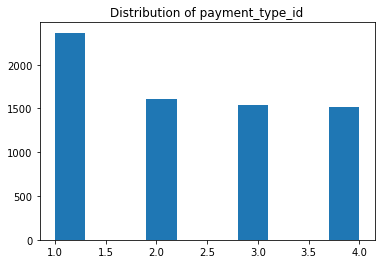

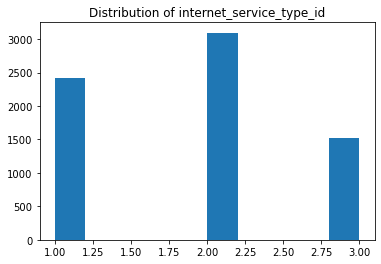

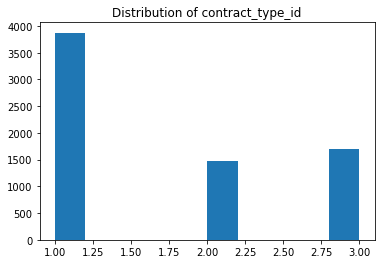

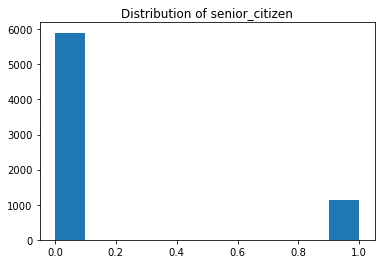

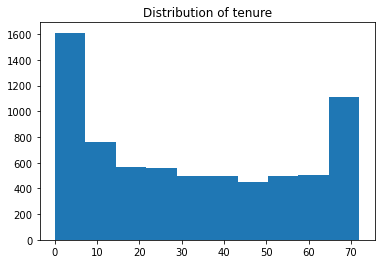

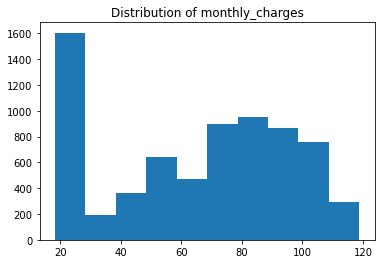

In [9]:
prepare.num_dist(df)

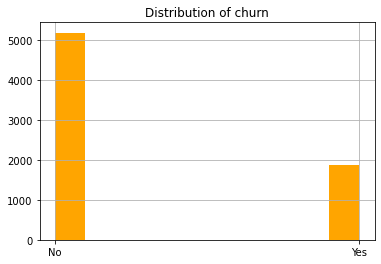

In [10]:
df['churn'].hist(color='orange', figsize=(6,4))

plt.title('Distribution of churn')
plt.show()

### Key Takeaway for Acquire
- Contract type monthly is less likely to churn
- out of the 7043 customers, the churn is under 2000 customers

## Prepare Data
- I have created functions needed to acuire data from the Telco database and placed them in my prepare.py file
- Import the telco_split function which has the train, validate, test
- Check out the distributions of numeric columns to get the categorical variables

In [11]:
df = prepare.prep_telco(df)
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,0,0,1,1,0,0,0,0,0,1
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,0,0,1,1,0,0,0,1,0,0
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,0,0,1,1,0,0,1,0,0,0
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,0,0,1,1,0,0,0,1,0,0
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,0,0,1,1,0,0,1,0,0,0


In [12]:
train, validate, test = prepare.telco_split(df)

In [13]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3943, 67)
validate -> (1691, 67)
test -> (1409, 67)


In [14]:
# check the dtypes for columns
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5466 to 1893
Data columns (total 67 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   payment_type_id                         3943 non-null   int64  
 1   internet_service_type_id                3943 non-null   int64  
 2   contract_type_id                        3943 non-null   int64  
 3   customer_id                             3943 non-null   object 
 4   gender                                  3943 non-null   object 
 5   senior_citizen                          3943 non-null   int64  
 6   partner                                 3943 non-null   object 
 7   dependents                              3943 non-null   object 
 8   tenure                                  3943 non-null   int64  
 9   phone_service                           3943 non-null   object 
 10  multiple_lines                          3943 non-null   o

## Clean the data
- Drop any duplicates if there are any and recheck the shape of the data to see if anything has been dropped
- change total_charges to float so that we can use them in our exploration and modeling
- Review the correlation between each column and churn to see which ones closely correlate

In [15]:
# for the two numerical variables monthly_charges and tenure, we dont see any evidence of relationship - has no use
df[['monthly_charges', 'tenure']].corr()

,monthly_charges,tenure
monthly_charges,1.0000,0.2479
tenure,0.2479,1.0000


In [16]:
# creating correlation table - review correlation on everything in comparison to churn
df_corr = df.corr().reset_index()
df_corr.head()

,index,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges,total_charges,gender_Female,gender_Male,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,payment_type_id,1.000000,0.008124,0.358913,-0.093704,0.340305,-0.074353,0.114336,0.005209,-0.005209,...,-0.347335,0.113981,0.295762,0.088956,-0.182323,0.117102,0.315658,0.769806,-0.814266,-0.149682
1,internet_service_type_id,0.008124,1.000000,0.099721,-0.032310,-0.030359,-0.323260,-0.082639,0.000863,-0.000863,...,-0.079919,-0.008904,0.101475,-0.856353,0.152555,0.803477,-0.017581,-0.032540,-0.091881,0.152481
2,contract_type_id,0.358913,0.099721,1.000000,-0.142554,0.671607,-0.074195,0.203353,-0.000126,0.000126,...,-0.915972,0.190926,0.884292,0.055352,-0.254157,0.242388,0.186440,0.210659,-0.342575,-0.004882
3,senior_citizen,-0.093704,-0.032310,-0.142554,1.000000,0.016567,0.220173,0.045504,0.001874,-0.001874,...,0.138360,-0.046262,-0.117000,-0.108322,0.255338,-0.182742,-0.016159,-0.024135,0.171718,-0.153477
4,tenure,0.340305,-0.030359,0.671607,0.016567,1.000000,0.247900,0.389632,-0.005106,0.005106,...,-0.645561,0.202570,0.558533,0.013274,0.019720,-0.039062,0.243510,0.233006,-0.208363,-0.233852


In [17]:
# rename columns in correlation table - changes index column renames to col_names
df_corr.rename(columns={'index': 'col_names'}, inplace=True)

In [18]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   col_names                               50 non-null     object 
 1   payment_type_id                         50 non-null     float64
 2   internet_service_type_id                50 non-null     float64
 3   contract_type_id                        50 non-null     float64
 4   senior_citizen                          50 non-null     float64
 5   tenure                                  50 non-null     float64
 6   monthly_charges                         50 non-null     float64
 7   total_charges                           50 non-null     float64
 8   gender_Female                           50 non-null     float64
 9   gender_Male                             50 non-null     float64
 10  partner_No                              50 non-null     float64


In [19]:
# Filter columns to only churn_no and churn_yes and transpose table
df_corr= df_corr[(df_corr.col_names=='churn_No') | (df_corr.col_names=='churn_Yes')].T.reset_index()
df_corr

,index,38,39
0,col_names,churn_No,churn_Yes
1,payment_type_id,0.262818,-0.262818
2,internet_service_type_id,0.0472914,-0.0472914
3,contract_type_id,0.396713,-0.396713
4,senior_citizen,-0.150889,0.150889
5,tenure,0.352229,-0.352229
6,monthly_charges,-0.193356,0.193356
7,total_charges,0.0987746,-0.0987746
8,gender_Female,-0.0086121,0.0086121
9,gender_Male,0.0086121,-0.0086121


In [20]:
df_corr.columns

Index(['index', 38, 39], dtype='object')

In [21]:
df_corr= df_corr.rename(columns={38:"churn_No", 39: "churn_Yes"})

In [22]:
df_corr= df_corr.drop([0], axis=0)

In [23]:
df_corr.sort_values(by='churn_No')

,index,churn_No,churn_Yes
40,churn_Yes,-1,1
41,contract_type_Month-to-month,-0.405103,0.405103
19,online_security_No,-0.342637,0.342637
28,tech_support_No,-0.337281,0.337281
45,internet_service_type_Fiber optic,-0.30802,0.30802
49,payment_type_Electronic check,-0.301919,0.301919
22,online_backup_No,-0.268005,0.268005
25,device_protection_No,-0.252481,0.252481
6,monthly_charges,-0.193356,0.193356
38,paperless_billing_Yes,-0.191825,0.191825


In [24]:
df.head(3)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,0,0,1,1,0,0,0,0,0,1
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,0,0,1,1,0,0,0,1,0,0
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,0,0,1,1,0,0,1,0,0,0


In [25]:
train.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
5466,4,2,1,9796-BPKIW,Male,1,No,No,8,Yes,...,1,0,0,0,1,0,0,1,0,0
1289,2,1,1,0836-SEYLU,Male,0,Yes,No,9,No,...,1,0,0,1,0,0,0,0,0,1
399,1,1,3,6504-VBLFL,Male,0,Yes,No,55,Yes,...,0,0,1,1,0,0,0,0,1,0
5976,3,3,3,7205-BAIAD,Female,0,No,No,40,Yes,...,0,0,1,0,0,1,1,0,0,0
4633,1,2,1,5666-CYCYZ,Female,0,No,No,24,Yes,...,1,0,0,0,1,0,0,0,1,0


<AxesSubplot:xlabel='contract_type', ylabel='Count'>

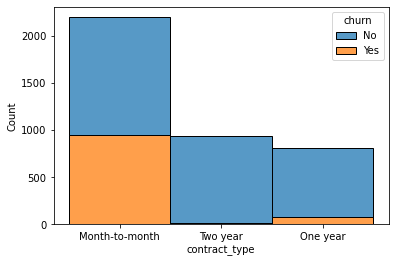

In [26]:
sns.histplot(data=train, x="contract_type", hue = "churn", multiple="stack")

Text(0.5, 0, 'Churn')

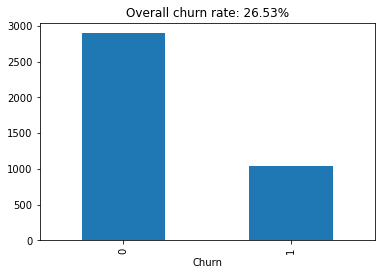

In [27]:
train.churn_Yes.value_counts().sort_index().plot.bar()
churn_rate = train.churn_Yes.mean()
plt.title(f"Overall churn rate: {churn_rate:.2%}")
plt.xlabel('Churn')

## Data Exploration

- $H_o$: There is no association between service types and churn.
- $H_a$: There is an association between service types and churn.

In [28]:
observed = pd.crosstab(train.internet_service_type_id, train.churn, margins=True)
observed

churn,No,Yes,All
internet_service_type_id,,,
1,1111,262,1373
2,1006,722,1728
3,780,62,842
All,2897,1046,3943


In [29]:
# set our alpha
alpha = 0.01

In [30]:
# chi2 contingency return 4 different values
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [31]:
print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected.astype(int))
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1111  262 1373]
 [1006  722 1728]
 [ 780   62  842]
 [2897 1046 3943]]
---
Expected

[[1008  364 1373]
 [1269  458 1728]
 [ 618  223  842]
 [2897 1046 3943]]
---

chi^2 = 404.0232
p     = 0.0000


In [32]:
if p < alpha:
    print('We reject the null')
else:
    print("we fail to reject the null")

We reject the null


In [33]:
# tenure with churn t-test

- $H_o$: There is no association between tenure types and churn.
- $H_a$: There is an association between tenure types and churn.

In [34]:
pd.crosstab(train.tenure, train.churn, margins=True)

churn,No,Yes,All
tenure,,,
0,7,0,7
1,130,229,359
2,68,68,136
3,65,60,125
4,54,44,98
5,40,40,80
6,35,22,57
7,40,27,67
8,45,21,66


## Modeling and Exploration
- Here we will go through the modeling stage and split into train, validate, test
- Review the baseline and create a column for the baseline_prediction to compare it to the acutal churn for each customer

In [35]:
df.columns = df.columns.str.replace(' ', '')

In [36]:
# Modeling stage
# split into train, validate, test
train, validate, test = prepare.telco_split(df)

In [37]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

In [38]:
X_train.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_Oneyear,contract_type_Twoyear,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck
5466,4,2,1,9796-BPKIW,Male,1,No,No,8,Yes,...,1,0,0,0,1,0,0,1,0,0
1289,2,1,1,0836-SEYLU,Male,0,Yes,No,9,No,...,1,0,0,1,0,0,0,0,0,1
399,1,1,3,6504-VBLFL,Male,0,Yes,No,55,Yes,...,0,0,1,1,0,0,0,0,1,0
5976,3,3,3,7205-BAIAD,Female,0,No,No,40,Yes,...,0,0,1,0,0,1,1,0,0,0
4633,1,2,1,5666-CYCYZ,Female,0,No,No,24,Yes,...,1,0,0,0,1,0,0,0,1,0


In [39]:
# looking for an algorithm that beats the 73% accuracy shown on the value counts
df.churn.value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: churn, dtype: float64

In [40]:
# Add baseline model to compare each model below
# Baseline Model
df['baseline_prediction'] = 'No'
df

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Oneyear,contract_type_Twoyear,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck,baseline_prediction
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,0,1,1,0,0,0,0,0,1,No
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,0,1,1,0,0,0,1,0,0,No
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,0,1,1,0,0,1,0,0,0,No
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,0,1,1,0,0,0,1,0,0,No
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,0,1,1,0,0,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2,3,1,9962-BFPDU,Female,0,Yes,Yes,1,Yes,...,0,0,0,0,1,0,0,0,1,No
7039,2,3,1,9967-ATRFS,Female,0,No,No,19,Yes,...,0,0,0,0,1,0,0,0,1,No
7040,4,3,1,9970-QBCDA,Female,0,No,No,6,Yes,...,0,0,0,0,1,0,1,0,0,No
7041,2,3,1,9975-SKRNR,Male,0,No,No,1,Yes,...,0,0,0,0,1,0,0,0,1,No


In [41]:
df[['baseline_prediction', 'churn']]

,baseline_prediction,churn
0,No,No
1,No,No
2,No,No
3,No,No
4,No,No
...,...,...
7038,No,No
7039,No,No
7040,No,No
7041,No,No


In [42]:
df[df.baseline_prediction != df.churn][['baseline_prediction', 'churn']]

,baseline_prediction,churn
44,No,Yes
194,No,Yes
203,No,Yes
253,No,Yes
326,No,Yes
...,...,...
6992,No,Yes
6997,No,Yes
7005,No,Yes
7012,No,Yes


In [43]:
len(df[df.baseline_prediction != df.churn][['baseline_prediction', 'churn']])/len(df)

0.2653698707936959

In [44]:
baseline_accuracy = (df.baseline_prediction == df.churn).mean()
baseline_accuracy

0.7346301292063041

In [45]:
## Model should do better than this baseline accuracy - this model will be better in predicting the accuracy

## MVP Model
- I'm going to run a decision tree with tenure, monthly_charges, dependents, partner, phone service
   
   - My goal is to beat my 73% baseline accuracy

In [46]:
features_selected = ['tenure', 'monthly_charges']

In [47]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [48]:
tree.fit(X_train[features_selected], y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [49]:
X_train.head().T

,5466,1289,399,5976,4633
payment_type_id,4,2,1,3,1
internet_service_type_id,2,1,1,3,2
contract_type_id,1,1,3,3,1
customer_id,9796-BPKIW,0836-SEYLU,6504-VBLFL,7205-BAIAD,5666-CYCYZ
gender,Male,Male,Male,Female,Female
senior_citizen,1,0,0,0,0
partner,No,Yes,Yes,No,No
dependents,No,No,No,No,No
tenure,8,9,55,40,24
phone_service,Yes,No,Yes,Yes,Yes


In [50]:
y_pred = tree.predict(X_train[features_selected])
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.82      0.91      0.86      2897
         Yes       0.65      0.44      0.53      1046

    accuracy                           0.79      3943
   macro avg       0.73      0.68      0.69      3943
weighted avg       0.77      0.79      0.77      3943



In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5466 to 1893
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   payment_type_id                       3943 non-null   int64  
 1   internet_service_type_id              3943 non-null   int64  
 2   contract_type_id                      3943 non-null   int64  
 3   customer_id                           3943 non-null   object 
 4   gender                                3943 non-null   object 
 5   senior_citizen                        3943 non-null   int64  
 6   partner                               3943 non-null   object 
 7   dependents                            3943 non-null   object 
 8   tenure                                3943 non-null   int64  
 9   phone_service                         3943 non-null   object 
 10  multiple_lines                        3943 non-null   object 
 11  online_securit

In [52]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(tree.score(X_train[features_selected], y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [53]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(tree.score(X_validate[features_selected], y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.78


In [54]:
# print('Accuracy of Decision Tree classifier on test set: {:.2f}'
#      .format(tree.score(X_test[features_selected], y_test)))

In [55]:
X_train.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_Oneyear,contract_type_Twoyear,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck
5466,4,2,1,9796-BPKIW,Male,1,No,No,8,Yes,...,1,0,0,0,1,0,0,1,0,0
1289,2,1,1,0836-SEYLU,Male,0,Yes,No,9,No,...,1,0,0,1,0,0,0,0,0,1
399,1,1,3,6504-VBLFL,Male,0,Yes,No,55,Yes,...,0,0,1,1,0,0,0,0,1,0
5976,3,3,3,7205-BAIAD,Female,0,No,No,40,Yes,...,0,0,1,0,0,1,1,0,0,0
4633,1,2,1,5666-CYCYZ,Female,0,No,No,24,Yes,...,1,0,0,0,1,0,0,0,1,0


On the new data the model predicts well.  the customers who are staying with the company and the customers who are leaving the company.  The precision metrics are very close between the test data and the train data

### Decision Tree2

In [56]:
features2 = ['payment_type_Creditcard(automatic)', 'payment_type_Electroniccheck']

In [57]:
tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [58]:
tree2.fit(X_train[features2], y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [59]:
X_train.head().T

,5466,1289,399,5976,4633
payment_type_id,4,2,1,3,1
internet_service_type_id,2,1,1,3,2
contract_type_id,1,1,3,3,1
customer_id,9796-BPKIW,0836-SEYLU,6504-VBLFL,7205-BAIAD,5666-CYCYZ
gender,Male,Male,Male,Female,Female
senior_citizen,1,0,0,0,0
partner,No,Yes,Yes,No,No
dependents,No,No,No,No,No
tenure,8,9,55,40,24
phone_service,Yes,No,Yes,Yes,Yes


In [60]:
y_pred = tree.predict(X_train[features2])
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.73      1.00      0.85      2897
         Yes       0.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.37      0.50      0.42      3943
weighted avg       0.54      0.73      0.62      3943



In [61]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(tree2.score(X_train[features2], y_train)))

Accuracy of Decision Tree classifier on training set: 0.73


In [62]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(tree2.score(X_validate[features2], y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.73


## Using Random Forest method

In [63]:
X_train.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_Oneyear,contract_type_Twoyear,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck
5466,4,2,1,9796-BPKIW,Male,1,No,No,8,Yes,...,1,0,0,0,1,0,0,1,0,0
1289,2,1,1,0836-SEYLU,Male,0,Yes,No,9,No,...,1,0,0,1,0,0,0,0,0,1
399,1,1,3,6504-VBLFL,Male,0,Yes,No,55,Yes,...,0,0,1,1,0,0,0,0,1,0
5976,3,3,3,7205-BAIAD,Female,0,No,No,40,Yes,...,0,0,1,0,0,1,1,0,0,0
4633,1,2,1,5666-CYCYZ,Female,0,No,No,24,Yes,...,1,0,0,0,1,0,0,0,1,0


In [64]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [65]:
rf.fit(X_train[features2], y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [66]:
print(rf.feature_importances_)

[0.12023942 0.87976058]


In [67]:
y_pred = rf.predict(X_train[features_selected])
y_pred

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [68]:
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf.score(X_train[features_selected], y_train)))

Accuracy of Random Forest classifier on training set: 0.73


In [69]:
print(confusion_matrix(y_train, y_pred))

[[2897    0]
 [1046    0]]


In [70]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.73      1.00      0.85      2897
         Yes       0.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.37      0.50      0.42      3943
weighted avg       0.54      0.73      0.62      3943



In [71]:
# print('Accuracy of random forest classifier on test set: {:.2f}'
#     .format(rf.score(X_validate[features_selected], y_validate)))

## Random Forest on [features2]

In [72]:
rf.fit(X_train[features2], y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [73]:
print(rf.feature_importances_)

[0.12023942 0.87976058]


In [74]:
y_pred = rf.predict(X_train[features2])
y_pred

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [75]:
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf.score(X_train[features2], y_train)))

Accuracy of Random Forest classifier on training set: 0.73


In [76]:
print(confusion_matrix(y_train, y_pred))

[[2897    0]
 [1046    0]]


In [77]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.73      1.00      0.85      2897
         Yes       0.00      0.00      0.00      1046

    accuracy                           0.73      3943
   macro avg       0.37      0.50      0.42      3943
weighted avg       0.54      0.73      0.62      3943



### Predictions

In [78]:
#Predictions
test.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_Oneyear,contract_type_Twoyear,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck
4066,1,2,1,3162-ZJZFU,Male,0,Yes,Yes,53,Yes,...,1,0,0,0,1,0,0,0,1,0
6607,2,3,1,1724-IQWNM,Male,0,No,Yes,1,Yes,...,1,0,0,0,0,1,0,0,0,1
992,4,1,2,6440-DKQGE,Male,0,No,Yes,30,Yes,...,0,1,0,1,0,0,0,1,0,0
3357,3,2,2,9391-YZEJW,Female,0,No,No,62,Yes,...,0,1,0,0,1,0,1,0,0,0
4868,3,2,1,6847-KJLTS,Female,1,Yes,No,58,Yes,...,1,0,0,0,1,0,1,0,0,0


In [79]:
predicted_test = tree.predict(X_test[features_selected])

In [80]:
X_test.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_Oneyear,contract_type_Twoyear,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck
4066,1,2,1,3162-ZJZFU,Male,0,Yes,Yes,53,Yes,...,1,0,0,0,1,0,0,0,1,0
6607,2,3,1,1724-IQWNM,Male,0,No,Yes,1,Yes,...,1,0,0,0,0,1,0,0,0,1
992,4,1,2,6440-DKQGE,Male,0,No,Yes,30,Yes,...,0,1,0,1,0,0,0,1,0,0
3357,3,2,2,9391-YZEJW,Female,0,No,No,62,Yes,...,0,1,0,0,1,0,1,0,0,0
4868,3,2,1,6847-KJLTS,Female,1,Yes,No,58,Yes,...,1,0,0,0,1,0,1,0,0,0


In [81]:
decisiontree_train_accuracy = tree.score(X_train[features_selected], y_train)
decisiontree_train_accuracy2 = tree2.score(X_train[features2], y_train)
random_forest_train_accuracy = rf.score(X_train[features2], y_train)

decisiontree_validate_accuracy = tree.score(X_validate[features_selected], y_validate)
decisiontree_validate_accuracy2 = tree2.score(X_validate[features2], y_validate)
random_forest_validate_accuracy = rf.score(X_validate[features2], y_validate)
print('\n')
print(f'The baseline accuracy is {baseline_accuracy}%')
print('\n')

print(f"Decision Tree Train Accuracy --- {decisiontree_train_accuracy:.2%}")
print(f"Decision Tree Train Accuracy2 --- {decisiontree_train_accuracy2:.2%}")
print(f"Random Forest Train Accuracy --- {random_forest_train_accuracy:.2%}")

print('\n')
print(f"Decision Tree Validate Accuracy --- {decisiontree_validate_accuracy:.2%}")
print(f"Decision Tree Validate Accuracy2 --- {decisiontree_validate_accuracy2:.2%}")
print(f"Random Forest Validate Accuracy --- {random_forest_validate_accuracy:.2%}")



The baseline accuracy is 0.7346301292063041%


Decision Tree Train Accuracy --- 78.85%
Decision Tree Train Accuracy2 --- 73.47%
Random Forest Train Accuracy --- 73.47%


Decision Tree Validate Accuracy --- 78.47%
Decision Tree Validate Accuracy2 --- 73.45%
Random Forest Validate Accuracy --- 73.45%


In [82]:
# The first Decision Tree has the most accurate and is closer between the Train and validate accuracy

### CSV file 

In [83]:
#Predictions
test.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,contract_type_Month-to-month,contract_type_Oneyear,contract_type_Twoyear,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck
4066,1,2,1,3162-ZJZFU,Male,0,Yes,Yes,53,Yes,...,1,0,0,0,1,0,0,0,1,0
6607,2,3,1,1724-IQWNM,Male,0,No,Yes,1,Yes,...,1,0,0,0,0,1,0,0,0,1
992,4,1,2,6440-DKQGE,Male,0,No,Yes,30,Yes,...,0,1,0,1,0,0,0,1,0,0
3357,3,2,2,9391-YZEJW,Female,0,No,No,62,Yes,...,0,1,0,0,1,0,1,0,0,0
4868,3,2,1,6847-KJLTS,Female,1,Yes,No,58,Yes,...,1,0,0,0,1,0,1,0,0,0


In [84]:
# what i need for my csv file
proba_test = tree.predict_proba(X_test[features_selected])

In [85]:
proba_test

array([[0.76470588, 0.23529412],
       [0.60810811, 0.39189189],
       [0.76470588, 0.23529412],
       ...,
       [0.76470588, 0.23529412],
       [0.92609351, 0.07390649],
       [0.83896104, 0.16103896]])

In [86]:
proba_df = pd.DataFrame(proba_test, columns = tree.classes_.tolist())
proba_df.head()

,No,Yes
0,0.764706,0.235294
1,0.608108,0.391892
2,0.764706,0.235294
3,0.926094,0.073906
4,0.764706,0.235294


In [87]:
# reset the index
reset_test = test.reset_index()
reset_test.head()

,index,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,contract_type_Month-to-month,contract_type_Oneyear,contract_type_Twoyear,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck
0,4066,1,2,1,3162-ZJZFU,Male,0,Yes,Yes,53,...,1,0,0,0,1,0,0,0,1,0
1,6607,2,3,1,1724-IQWNM,Male,0,No,Yes,1,...,1,0,0,0,0,1,0,0,0,1
2,992,4,1,2,6440-DKQGE,Male,0,No,Yes,30,...,0,1,0,1,0,0,0,1,0,0
3,3357,3,2,2,9391-YZEJW,Female,0,No,No,62,...,0,1,0,0,1,0,1,0,0,0
4,4868,3,2,1,6847-KJLTS,Female,1,Yes,No,58,...,1,0,0,0,1,0,1,0,0,0


In [88]:
# concatenate resetted test and the probabilities

test_proba_df = pd.concat([reset_test, proba_df], axis=1)
test_proba_df.head()

,index,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,contract_type_Twoyear,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck,No,Yes
0,4066,1,2,1,3162-ZJZFU,Male,0,Yes,Yes,53,...,0,0,1,0,0,0,1,0,0.764706,0.235294
1,6607,2,3,1,1724-IQWNM,Male,0,No,Yes,1,...,0,0,0,1,0,0,0,1,0.608108,0.391892
2,992,4,1,2,6440-DKQGE,Male,0,No,Yes,30,...,0,1,0,0,0,1,0,0,0.764706,0.235294
3,3357,3,2,2,9391-YZEJW,Female,0,No,No,62,...,0,0,1,0,1,0,0,0,0.926094,0.073906
4,4868,3,2,1,6847-KJLTS,Female,1,Yes,No,58,...,0,0,1,0,1,0,0,0,0.764706,0.235294


In [89]:
test_proba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 70 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   index                                 1409 non-null   int64  
 1   payment_type_id                       1409 non-null   int64  
 2   internet_service_type_id              1409 non-null   int64  
 3   contract_type_id                      1409 non-null   int64  
 4   customer_id                           1409 non-null   object 
 5   gender                                1409 non-null   object 
 6   senior_citizen                        1409 non-null   int64  
 7   partner                               1409 non-null   object 
 8   dependents                            1409 non-null   object 
 9   tenure                                1409 non-null   int64  
 10  phone_service                         1409 non-null   object 
 11  multiple_lines   

In [90]:
# adding a predited result column
test_proba_df['predicted'] = predicted_test
test_proba_df.head()

,index,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,internet_service_type_DSL,internet_service_type_Fiberoptic,internet_service_type_None,payment_type_Banktransfer(automatic),payment_type_Creditcard(automatic),payment_type_Electroniccheck,payment_type_Mailedcheck,No,Yes,predicted
0,4066,1,2,1,3162-ZJZFU,Male,0,Yes,Yes,53,...,0,1,0,0,0,1,0,0.764706,0.235294,No
1,6607,2,3,1,1724-IQWNM,Male,0,No,Yes,1,...,0,0,1,0,0,0,1,0.608108,0.391892,No
2,992,4,1,2,6440-DKQGE,Male,0,No,Yes,30,...,1,0,0,0,1,0,0,0.764706,0.235294,No
3,3357,3,2,2,9391-YZEJW,Female,0,No,No,62,...,0,1,0,1,0,0,0,0.926094,0.073906,No
4,4868,3,2,1,6847-KJLTS,Female,1,Yes,No,58,...,0,1,0,1,0,0,0,0.764706,0.235294,No


In [91]:
# keep only columns you want to keep

csv_df = test_proba_df[['customer_id', 'internet_service_type_id', 'No', 'Yes', 'predicted']]
csv_df.head()

,customer_id,internet_service_type_id,No,Yes,predicted
0,3162-ZJZFU,2,0.764706,0.235294,No
1,1724-IQWNM,3,0.608108,0.391892,No
2,6440-DKQGE,1,0.764706,0.235294,No
3,9391-YZEJW,2,0.926094,0.073906,No
4,6847-KJLTS,2,0.764706,0.235294,No


In [92]:
csv_df.to_csv('predictions.csv')

## Recommendations

## Key Takeaways, Recommendations, & Next Steps

### Through this classification project I came away with the following key takeways:
- The baseline accuracy is 73.5%.  The Decision Tree train gave me an accuracy of 78.85% and the validate accuracy gave me 78.47% which had a small marginal difference.
- The baseleine accuracy was beat by about 5%


### Conclusions
- Overall, the churn rate was 26.57%

### Recommendations & next steps:
- I would recommend a employer discount to large companies to entice their employees to have service with us and bring in large amounts of customers.
- A feature I would have liked to create would be a column based on the number of services a customer has. I believe that the more services a person has, the less likely will leave the more services they have.
- I believe an age column would be helpful between senior_citizens and not_senior to direct our marketing appropriately.
- Another column of information that could be helpful is area of residence to see if perhaps there is a concentration of where churn is occuring